In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import scale

from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.layers.normalization import BatchNormalization
from keras.initializers import Initializer
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


Using TensorFlow backend.


In [2]:
raw_data = pd.read_csv('./data/ordered_molecules.csv')

In [3]:
raw_data.head()

,time,molecule,px,py,pz,ax,ay,az
0,0,1,0.27497,0.22765,0.40548,1.185458,-1.527830,-4.614324
1,0,2,2.13410,1.61428,1.62211,-4.601109,-0.659241,1.090967
2,0,3,12.05408,12.60878,2.90295,4.530882,-2.598597,2.008448
3,0,4,0.85376,1.93829,4.87515,3.975239,0.917088,-2.261618
4,0,5,12.70257,0.12956,6.09076,-1.861295,-0.908830,5.337542


In [4]:
raw_data.iloc[:,2:] = scale(raw_data.iloc[:,2:], axis = 0)

In [5]:
raw_data_scaled = raw_data

In [6]:
raw_data_scaled.head()

,time,molecule,px,py,pz,ax,ay,az
0,0,1,-1.644088,-1.687248,-1.622801,0.433043,-0.557533,-1.614066
1,0,2,-1.146260,-1.315603,-1.297500,-1.680760,-0.240568,0.381615
2,0,3,1.510062,1.631154,-0.955030,1.655108,-0.948277,0.702545
3,0,4,-1.489103,-1.228761,-0.427706,1.452135,0.334665,-0.791101
4,0,5,1.683712,-1.713539,-0.102678,-0.679920,-0.331648,1.867045


In [7]:
target_data = raw_data_scaled.iloc[128:,2:]
data = pd.concat([raw_data_scaled.iloc[0:255872,:].reset_index(drop=True), target_data.reset_index(drop=True)], axis = 1, ignore_index=True)

In [8]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,1,-1.644088,-1.687248,-1.622801,0.433043,-0.557533,-1.614066,-1.643419,-1.687447,-1.623753,0.428789,-0.562693,-1.620018
1,0,2,-1.146260,-1.315603,-1.297500,-1.680760,-0.240568,0.381615,-1.146375,-1.313517,-1.298369,-1.706684,-0.293925,0.372428
2,0,3,1.510062,1.631154,-0.955030,1.655108,-0.948277,0.702545,1.510726,1.631180,-0.957386,1.618997,-0.952184,0.774350
3,0,4,-1.489103,-1.228761,-0.427706,1.452135,0.334665,-0.791101,-1.487831,-1.228078,-0.426671,1.405047,0.302387,-0.800858
4,0,5,1.683712,-1.713539,-0.102678,-0.679920,-0.331648,1.867045,1.683602,-1.713879,-0.101376,-0.654165,-0.308364,1.838234


In [9]:
diff_x = data.iloc[:,8] - data.iloc[:,2]
diff_y = data.iloc[:,9] - data.iloc[:,3]
diff_z = data.iloc[:,10] - data.iloc[:,4]


diff_x_idx, = np.where(abs(diff_x) > 3)
diff_y_idx, = np.where(abs(diff_y) > 3)
diff_z_idx, = np.where(abs(diff_z) > 3)

diff_idx = set(diff_x_idx) | set(diff_y_idx) | set(diff_z_idx)

final_data = data.loc[data.index.drop(list(diff_idx))]

In [10]:
x_train, x_test, y_train, y_test = train_test_split(final_data.iloc[:,2:8], 
                                                    final_data.iloc[:,8:], 
                                                    test_size = 0.3, random_state = 10)

In [12]:
#model 1
model_1 = Sequential()

model_1.add(Dense(32, input_dim=6, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))

model_1.add(Dense(32, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))

model_1.add(Dense(32, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))

model_1.add(Dense(6, activation='linear', kernel_initializer = 'glorot_normal', kernel_regularizer = regularizers.l2(0.01)))

In [13]:
model_1.compile(loss='mean_absolute_error', optimizer= "rmsprop", metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, mode='min')
model_check_point = ModelCheckpoint('./model/DNN.h5', monitor = 'val_loss', verbose=2, save_best_only=True)
callback_list = [model_check_point, early_stop]

In [14]:
hist_1 = model_1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=150, batch_size=64, callbacks = callback_list)

Train on 178881 samples, validate on 76664 samples
Epoch 1/150
178881/178881 [==============================] - 6s 34us/step - loss: 0.5082 - mean_absolute_error: 0.1055 - val_loss: 0.3878 - val_mean_absolute_error: 0.1102

Epoch 00001: val_loss improved from inf to 0.38776, saving model to ./model/DNN.h5
Epoch 2/150
178881/178881 [==============================] - 5s 30us/step - loss: 0.3454 - mean_absolute_error: 0.0756 - val_loss: 0.4009 - val_mean_absolute_error: 0.1369

Epoch 00002: val_loss did not improve from 0.38776
Epoch 3/150
178881/178881 [==============================] - 5s 31us/step - loss: 0.3335 - mean_absolute_error: 0.0727 - val_loss: 0.3998 - val_mean_absolute_error: 0.1400

Epoch 00003: val_loss did not improve from 0.38776
Epoch 4/150
178881/178881 [==============================] - 5s 30us/step - loss: 0.3284 - mean_absolute_error: 0.0718 - val_loss: 0.3420 - val_mean_absolute_error: 0.0873

Epoch 00004: val_loss improved from 0.38776 to 0.34196, saving model to 

In [15]:
model = load_model('./model/DNN.h5')

In [16]:
y_pred = model.predict(x_test)

In [17]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae_metric = mean_absolute_error(y_test, y_pred)
r2_error = r2_score(y_test, y_pred)

In [18]:
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae_metric)
print("R2_Score:", r2_error)

MSE:  0.00480270910131714
RMSE:  0.0693015807995542
MAE:  0.044095367827461616
R2_Score: 0.9951889835058968


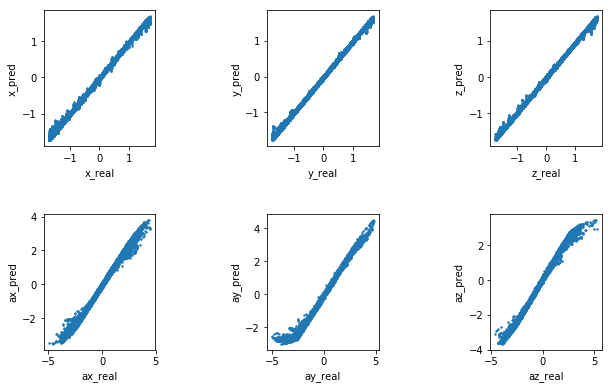

In [19]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)

ax1.scatter(y_test.values[:,0], y_pred[:,0], s= 2)
ax1.set_xlabel('x_real')
ax1.set_ylabel('x_pred')
ax2.scatter(y_test.values[:,1], y_pred[:,1], s= 2)
ax2.set_xlabel('y_real')
ax2.set_ylabel('y_pred')
ax3.scatter(y_test.values[:,2], y_pred[:,2], s= 2)
ax3.set_xlabel('z_real')
ax3.set_ylabel('z_pred')
ax4.scatter(y_test.values[:,3], y_pred[:,3], s= 2)
ax4.set_xlabel('ax_real')
ax4.set_ylabel('ax_pred')
ax5.scatter(y_test.values[:,4], y_pred[:,4], s= 2)
ax5.set_xlabel('ay_real')
ax5.set_ylabel('ay_pred')
ax6.scatter(y_test.values[:,5], y_pred[:,5], s= 2)
ax6.set_xlabel('az_real')
ax6.set_ylabel('az_pred')

plt.subplots_adjust(wspace = 1, hspace = 0.5)
plt.show()

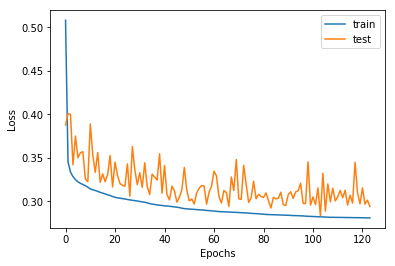

In [20]:
# plot history
plt.plot(hist_1.history['loss'], label='train')
plt.plot(hist_1.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
#cross validation

kfold = KFold(n_splits=20, shuffle=True, random_state = 500)
X = final_data.iloc[:,2:8]
Y = final_data.iloc[:,8:]

cv_rmse = []
cv_mae = []
cv_r2 = []

for train, test in kfold.split(X, Y):
    
    # evaluate the model
    pred = model.predict(X.iloc[test,:])
    
    rmse = np.sqrt(mean_squared_error(Y.iloc[test,:], pred))
    mae = mean_absolute_error(Y.iloc[test,:], pred)
    r2 = r2_score(Y.iloc[test,:], pred)
    
    cv_rmse.append(rmse)
    cv_mae.append(mae)
    cv_r2.append(r2)

In [23]:
print(np.mean(cv_rmse))
print(np.std(cv_rmse))
print('\n')

print(np.mean(cv_mae))
print(np.std(cv_mae))
print('\n')

print(np.mean(cv_r2))
print(np.std(cv_r2))

0.06977224745536412
0.0015830064242169052


0.044104826709153264
0.00024714902503377226


0.995130129327053
0.00020670811573464062


In [24]:
###############################################################################

원래 scale 로 변환

In [25]:
raw_data = pd.read_csv('./data/ordered_molecules.csv')

In [26]:
px_mean = np.mean(raw_data['px'])
px_std = np.std(raw_data['px'])
py_mean = np.mean(raw_data['py'])
py_std = np.std(raw_data['py'])
pz_mean = np.mean(raw_data['pz'])
pz_std = np.std(raw_data['pz'])

ax_mean = np.mean(raw_data['ax'])
ax_std = np.std(raw_data['ax'])
ay_mean = np.mean(raw_data['ay'])
ay_std = np.std(raw_data['ay'])
az_mean = np.mean(raw_data['az'])
az_std = np.std(raw_data['az'])

In [27]:
y_test.iloc[:,0] = y_test.iloc[:,0] * px_std + px_mean
y_test.iloc[:,1] = y_test.iloc[:,1] * py_std + py_mean
y_test.iloc[:,2] = y_test.iloc[:,2] * pz_std + pz_mean

y_test.iloc[:,3] = y_test.iloc[:,3] * ax_std + ax_mean
y_test.iloc[:,4] = y_test.iloc[:,4] * ay_std + ay_mean
y_test.iloc[:,5] = y_test.iloc[:,5] * az_std + az_mean


In [28]:
y_pred_df = pd.DataFrame(y_pred)

In [29]:
y_pred_df.iloc[:,0] = y_pred_df.iloc[:,0] * px_std + px_mean
y_pred_df.iloc[:,1] = y_pred_df.iloc[:,1] * py_std + py_mean
y_pred_df.iloc[:,2] = y_pred_df.iloc[:,2] * pz_std + pz_mean

y_pred_df.iloc[:,3] = y_pred_df.iloc[:,3] * ax_std + ax_mean
y_pred_df.iloc[:,4] = y_pred_df.iloc[:,4] * ay_std + ay_mean
y_pred_df.iloc[:,5] = y_pred_df.iloc[:,5] * az_std + az_mean

In [30]:
mse = mean_squared_error(y_test, y_pred_df)
rmse = np.sqrt(mse)
mae_metric = mean_absolute_error(y_test, y_pred_df)
r2_error = r2_score(y_test, y_pred_df)

In [31]:
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae_metric)
print("R2_Score:", r2_error)

MSE:  0.0412855637882455
RMSE:  0.20318849324763816
MAE:  0.1365140569524609
R2_Score: 0.9951889842959835


In [32]:
#cross validation

kfold = KFold(n_splits=20, shuffle=True, random_state = 500)
X = final_data.iloc[:,2:8]
Y = final_data.iloc[:,8:]

cv_rmse = []
cv_mae = []
cv_r2 = []

for train, test in kfold.split(X, Y):
    y_test = Y.iloc[test,:]

    y_test.iloc[:,0] = y_test.iloc[:,0] * px_std + px_mean
    y_test.iloc[:,1] = y_test.iloc[:,1] * py_std + py_mean
    y_test.iloc[:,2] = y_test.iloc[:,2] * pz_std + pz_mean

    y_test.iloc[:,3] = y_test.iloc[:,3] * ax_std + ax_mean
    y_test.iloc[:,4] = y_test.iloc[:,4] * ay_std + ay_mean
    y_test.iloc[:,5] = y_test.iloc[:,5] * az_std + az_mean
    
    y_pred = model.predict(X.iloc[test,:])
    y_pred_df = pd.DataFrame(y_pred)
    
    y_pred_df.iloc[:,0] = y_pred_df.iloc[:,0] * px_std + px_mean
    y_pred_df.iloc[:,1] = y_pred_df.iloc[:,1] * py_std + py_mean
    y_pred_df.iloc[:,2] = y_pred_df.iloc[:,2] * pz_std + pz_mean

    y_pred_df.iloc[:,3] = y_pred_df.iloc[:,3] * ax_std + ax_mean
    y_pred_df.iloc[:,4] = y_pred_df.iloc[:,4] * ay_std + ay_mean
    y_pred_df.iloc[:,5] = y_pred_df.iloc[:,5] * az_std + az_mean
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_df))
    mae = mean_absolute_error(y_test, y_pred_df)
    r2 = r2_score(y_test, y_pred_df)
    
    cv_rmse.append(rmse)
    cv_mae.append(mae)
    cv_r2.append(r2)

/usr/local/anaconda/envs/env_py3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [33]:
print(np.mean(cv_rmse))
print(np.std(cv_rmse))
print('\n')

print(np.mean(cv_mae))
print(np.std(cv_mae))
print('\n')

print(np.mean(cv_r2))
print(np.std(cv_r2))

0.20444902761086053
0.004179614650112721


0.13652891554219054
0.0007402528311863369


0.995130130123423
0.0002067081149173496
